# Trabajo Práctico 1 : Reservas de Hotel

### Grupo 01 - Integrantes:
        Cabrera Rodríguez, Mateo 
        Gonzalez Alejo, Camila
        Bocanegra, Eduardo Martín

### Instalar dependencias

In [17]:
pip install -r ../requirements.txt

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.2.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


### Cargado de bibliotecas

In [18]:
# Datos
import numpy as np
import pandas as pd

# Plots
import matplotlib.pyplot as plt
import seaborn as sns

# Modelado
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, make_scorer, f1_score
from sklearn.metrics import confusion_matrix, classification_report
from xgboost import XGBClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

# Preprocesamiento
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing


### Cargado de Dataset

In [19]:
ds = pd.read_csv('../datasets/hoteles_train2.csv')
ds_test = pd.read_csv('../datasets/hotels_test.csv')

#### Trabajo sobre nulos

In [20]:
# Trabajo sobre valores nulos
agents = ds['agent'].unique()
agents = np.delete(agents, 1)
ds['agent'].fillna(0, inplace=True)

agents = ds_test['agent'].unique()
agents = np.delete(agents, 1)
ds_test['agent'].fillna(0, inplace=True)

#### Transformacion de variables categoricas

In [21]:
# Transformacion de variables categoricas

import string

# encoding ordinal

ds = ds.replace({'meal': {'BB': 0, 'HB': 1, 'FB': 2, 'SC': 3, 'Undefined': 3},
                 'arrival_date_month': {'January': 1, 'February': 2, 'March': 3, 'April': 4, 'May': 5, 'June': 6, 'July': 7, 'August': 8, 'September': 9, 'October': 10,'November': 11, 'December': 12},
                 'reserved_room_type': {a : n for n, a in enumerate(string.ascii_uppercase)},
                 'assigned_room_type': {a : n for n, a in enumerate(string.ascii_uppercase)},
                 'deposit_type': {'No Deposit': 0, 'Refundable': 1, 'Non Refund': 2},
                 'agent': {agent : 1 for agent in agents}})

ds_test = ds_test.replace({'meal': {'BB': 0, 'HB': 1, 'FB': 2, 'SC': 3, 'Undefined': 4},# ver que hacer con undefined
                 'arrival_date_month': {'January': 1, 'February': 2, 'March': 3, 'April': 4, 'May': 5, 'June': 6, 'July': 7, 'August': 8, 'September': 9, 'October': 10,'November': 11, 'December': 12},
                 'reserved_room_type': {a : n for n, a in enumerate(string.ascii_uppercase)},
                 'assigned_room_type': {a : n for n, a in enumerate(string.ascii_uppercase)},
                 'deposit_type': {'No Deposit': 0, 'Refundable': 1, 'Non Refund': 2},
                 'agent': {agent : 1 for agent in agents}})

# Si meal es Undefined o vacío, reemplazamos por SC (dice el paper)
# ds['meal'] = ds['meal'].apply(lambda x: 'SC' if x in ['Undefined', 'null', ''] else x)
# ds = pd.get_dummies(ds, columns=['assigned_room_type'], drop_first=True)
# ds = pd.get_dummies(ds, columns=['reserved_room_type'], drop_first=True)
# ds = pd.get_dummies(ds, columns=['meal'], drop_first=True)
# ds = pd.get_dummies(ds, columns=['deposit_type'], drop_first=True)
# ds = pd.get_dummies(ds, columns=['agent'], drop_first=True)

In [22]:
label_encoder = LabelEncoder()
ds['market_segment'] = label_encoder.fit_transform(ds['market_segment'])
ds['distribution_channel'] = label_encoder.fit_transform(ds['distribution_channel'])
ds['customer_type'] = label_encoder.fit_transform(ds['customer_type'])

ds_test['market_segment'] = label_encoder.fit_transform(ds_test['market_segment'])
ds_test['distribution_channel'] = label_encoder.fit_transform(ds_test['distribution_channel'])
ds_test['customer_type'] = label_encoder.fit_transform(ds_test['customer_type'])

#ds['arrival_date_month'] = label_encoder.fit_transform(ds['arrival_date_month'])

#### Separacion de datos

In [23]:
# Definicion de excluidos y target

excluidos = ['hotel', 'reservation_status_date', 'id']

target = 'is_canceled'
features = [col for col in ds.columns if col not in excluidos+[target]]

### Generacion del dataset de prueba

In [24]:
x = ds[features].values
y = ds[target].values

#Separo conjunto de Train y de Test (80/20)
x_train, x_test, y_train, y_test = train_test_split(x, y , test_size=0.20, random_state=0, stratify=ds[target])

### Definicion de la funcion metricas

In [25]:
def metricas(y_pred,y_test):

  print(classification_report(y_test,y_pred))
  
  cm = confusion_matrix(y_test,y_pred)
  sns.heatmap(cm, cmap='Blues',annot=True,fmt='g')
  plt.xlabel('Predicted')
  plt.ylabel('True')

### Diccionario de modelos y sus scores

In [26]:
models = {}
model_scores = {}

## Checkpoint 3

### K-Nearest Neighbors (KNN)

El algoritmo K-Nearest Neighbors, o simplemente KNN, funciona obteniendo un punto dado y evaluando sus "k" vecinos para encontrar similitudes. 

Se puede utilizar para clasificación o regresión.

La idea se basa en el hecho de que los puntos de datos similares estarán más cerca en el espacio que los puntos que son muy diferentes entre sí.  

#### Creacion de un modelo KNN con sus parametros por defecto

In [27]:
#Creamos el modelo
KNN_Classifier = KNeighborsClassifier()

#vemos sus parámetros
KNN_Classifier.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}

In [60]:
#Entrenamos el modelo
KNN_Classifier.fit(x_train, y_train)

#Predicción sobre test
y_pred = KNN_Classifier.predict(x_test)

In [61]:
#Cantidad de aciertos
print('correctas: ', np.sum(y_test == y_pred))
print('total: ', len(y_test))

correctas:  8983
total:  12343


#### Metricas

              precision    recall  f1-score   support

           0       0.72      0.74      0.73      6170
           1       0.73      0.72      0.72      6173

    accuracy                           0.73     12343
   macro avg       0.73      0.73      0.73     12343
weighted avg       0.73      0.73      0.73     12343



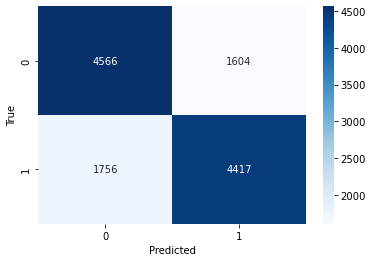

In [25]:
metricas(y_pred, y_test)

Precision: En este caso, la precisión para la clase 0 es del 0.72, lo que significa que el 72% de las predicciones clasificadas como clase 0 son realmente de la clase 0.

Recall: En este caso, el recall para la clase 0 es del 0.74, lo que indica que el 74% de las instancias de la clase 0 se han identificado correctamente. Y vemos quepara las instancias de clase 1, el 72% se ha identificado correctamente.

F1-score: Teniendo en cuenta que un valor de 1 indica un rendimiento perfecto, mientras que un valor de 0 indica un rendimiento pobre. En este caso, el f1-score para la clase 0 es del 0.73, lo que muestra un rendimiento aceptable para esa clase.

Exactitud: En este caso, la exactitud general del modelo es del 0.73, lo que indica que el 73% de las predicciones son correctas en general.

#### Buscamos los mejores hiperparametros mediante k-fold Cross Validation

In [16]:
# # Definir el rango de posibles valores para los hiperparámetros
# params_grid = {'n_neighbors': [3, 5, 7, 9],
#               'weights': ['uniform', 'distance'],
#               'metric': ['euclidean', 'manhattan','chebyshev']}

# # Crear una instancia de GridSearchCV con la grilla de hiperparámetros y la métrica de desempeño
# grid_search = GridSearchCV(estimator=KNN_Classifier, param_grid=params_grid, scoring='accuracy', cv=5)

# # Entrenar el modelo con GridSearchCV para encontrar los mejores hiperparámetros
# grid_search.fit(x_train, y_train)

# # Mostrar los mejores hiperparámetros y la métrica de desempeño del modelo
# print('Mejores hiperparámetros:', grid_search.best_params_)
# print('Mejor score:', grid_search.best_score_)

# #Primer intento de busqueda de hiperparametros ^

In [22]:
# Definir el rango de posibles valores para los hiperparámetros
# params_grid = {'n_neighbors': range(1,50),
#               'weights': ['uniform', 'distance'],
#               'metric': ['euclidean', 'manhattan','chebyshev', 'canberra', 'minkowski', 'cosine', 'correlation']}

params_grid = { 'n_neighbors': [30], 
                'weights': ['distance'],
                'metric': ['canberra'],}

# 'braycurtis','canberra','chebyshev','correlation',
#         'cosine','dice','hamming','jaccard','kulsinski',
#         'mahalanobis','matching','minkowski','rogerstanimoto',
#         'russellrao','seuclidean','sokalmichener','sokalsneath',
#         'sqeuclidean','yule','wminkowski',

# Crear una instancia de GridSearchCV con la grilla de hiperparámetros y la métrica de desempeño
grid_search = HalvingGridSearchCV(estimator=KNN_Classifier, param_grid=params_grid, scoring='accuracy', cv=5)

# Entrenar el modelo con GridSearchCV para encontrar los mejores hiperparámetros
grid_search.fit(x_train, y_train)

# Mostrar los mejores hiperparámetros y la métrica de desempeño del modelo
print('Mejores hiperparámetros:', grid_search.best_params_)
print('Mejor score:', grid_search.best_score_)

Mejores hiperparámetros: {'metric': 'canberra', 'n_neighbors': 30, 'weights': 'distance'}
Mejor score: 0.8118087907636216


###### Mejores hiperparámetros: {'metric': 'canberra', 'n_neighbors': 30, 'weights': 'distance'}

In [28]:
best_n_neighbors = 30
best_weights = 'distance'
best_metric = 'canberra'
best_score = 0.8118087907636216

best_knn = KNeighborsClassifier(n_neighbors=best_n_neighbors, weights=best_weights, metric=best_metric)

# Entrenar el modelo con los datos de entrenamiento
best_knn.fit(x_train, y_train)

# Realizar predicciones en datos de prueba
y_pred = best_knn.predict(x_test)

In [29]:
models["knn"] = best_knn
model_scores["knn"] = best_score

#### Metricas

              precision    recall  f1-score   support

           0       0.82      0.82      0.82      6184
           1       0.82      0.82      0.82      6159

    accuracy                           0.82     12343
   macro avg       0.82      0.82      0.82     12343
weighted avg       0.82      0.82      0.82     12343



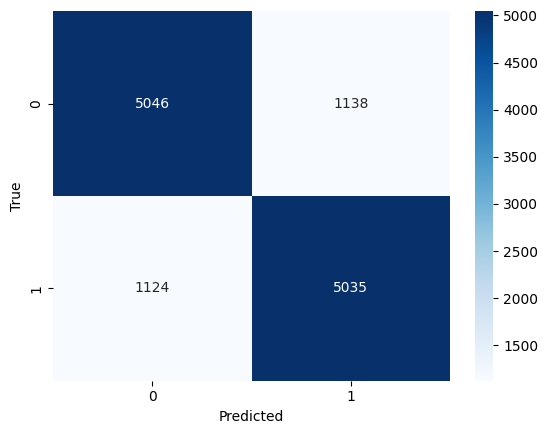

In [26]:
metricas(y_test,y_pred)

En este caso, tanto al precision, como F1-Score y el recall para las clase 0 y 1 son del 0.82. Lo que da una exactitud general del modelo de 0.82.

### Normalizacion de Datos + SVM (Probando distintos kernels)

#### Normalizacion de datos

In [30]:
#Version escalada
min_max_scaler = preprocessing.MinMaxScaler()
x_train_minmax = min_max_scaler.fit_transform(x_train) 
x_test_minmax  = min_max_scaler.transform(x_test) 

#Version estandarizada
stand_scaler = preprocessing.StandardScaler()
x_train_norm = stand_scaler.fit_transform(x_train)
x_test_norm=stand_scaler.transform(x_test)

#### Construccion de modelo SVM

In [66]:
svm = SVC()

#Lo entreno con los datos sin escalar
svm.fit(x_train, y_train)

# Realizar predicciones en datos de prueba
y_pred = svm.predict(x_test)

#### Metricas

              precision    recall  f1-score   support

           0       0.60      0.70      0.65      6170
           1       0.64      0.54      0.59      6173

    accuracy                           0.62     12343
   macro avg       0.62      0.62      0.62     12343
weighted avg       0.62      0.62      0.62     12343



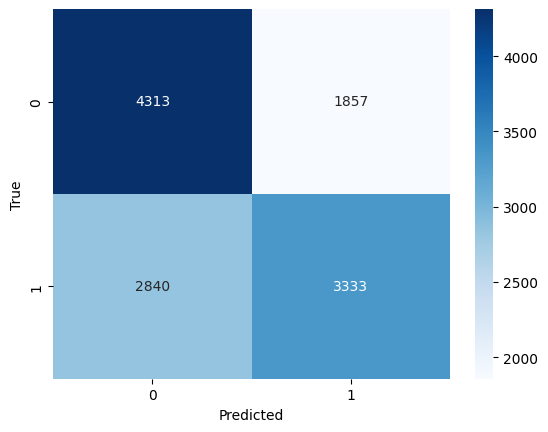

In [11]:
#Matriz de confusion
metricas(y_pred, y_test)

Precision: En este caso, la precisión para la clase 0 es del 0.60, lo que significa que el 60% de las predicciones clasificadas como clase 0 son realmente de la clase 0. 64% de aciertos para la clase 1.

Recall: En este caso, el recall para la clase 0 es del 0.70, lo que indica que el 70% de las instancias de la clase 0 se han identificado correctamente. Y vemos quepara las instancias de clase 1, el 54% se ha identificado correctamente.

F1-score: Teniendo en cuenta que un valor de 1 indica un rendimiento perfecto, mientras que un valor de 0 indica un rendimiento pobre. En este caso, el f1-score para la clase 0 es del 0.65, y para la clase 10.59, valores inferiores a los vistos previamente en otros analisis de metricas.

Exactitud: En este caso, la exactitud general del modelo es del 0.62, lo que indica que el 62%, como era de esperarse, bastante mas bajo que los modelos analizados anteriormente.

#### Modelo SVM (radial) con datos normalizados

In [16]:
svm_norm = SVC() # Parametros default (kernel: radial)

#Lo entreno con los datos escalados con normalizacion
svm_norm.fit(x_train_norm, y_train)

y_pred=svm_norm.predict(x_test)

#### Metricas

              precision    recall  f1-score   support

           0       0.50      1.00      0.67      6170
           1       0.00      0.00      0.00      6173

    accuracy                           0.50     12343
   macro avg       0.25      0.50      0.33     12343
weighted avg       0.25      0.50      0.33     12343



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


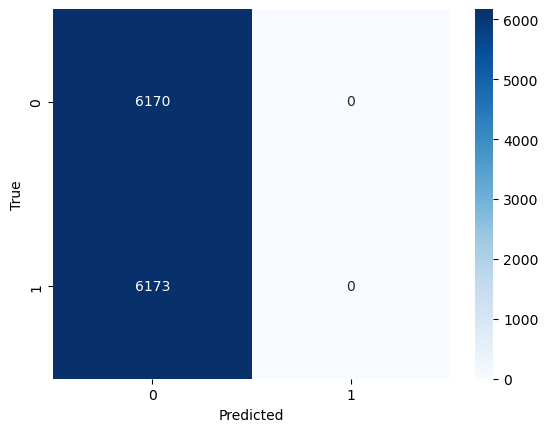

In [71]:
metricas(y_pred, y_test)

Precision: En este caso, la precisión para la clase 0 es del 0.50 y para la clase 1 0.00. Lo que ya indica que el modelo no sera bueno.

Recall: En este caso, el recall para la clase 0 es del 1, lo que indica que el 100% de las instancias de la clase 0 se han identificado correctamente. Y vemos quepara las instancias de clase 1, el 0% se ha identificado correctamente.

F1-score: Teniendo en cuenta que un valor de 1 indica un rendimiento perfecto, mientras que un valor de 0 indica un rendimiento pobre. En este caso, el f1-score para la clase 0 es del 0.67, y 0.00 para la clase 1.

Exactitud: En este caso, la exactitud general del modelo es del 0.50, lo que indica que el 50% de las predicciones son correctas en general.No es modelo que podamos utilizar, y es el peor encontrado hasta el momento.

#### Modelo SVM con minmax

In [72]:
svm_minmax= SVC()

#Lo entreno con los datos escalados con min max
svm_minmax.fit(x_train_minmax, y_train)

y_pred=svm_minmax.predict(x_test)

#### Metricas

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      6170
           1       0.50      1.00      0.67      6173

    accuracy                           0.50     12343
   macro avg       0.25      0.50      0.33     12343
weighted avg       0.25      0.50      0.33     12343



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


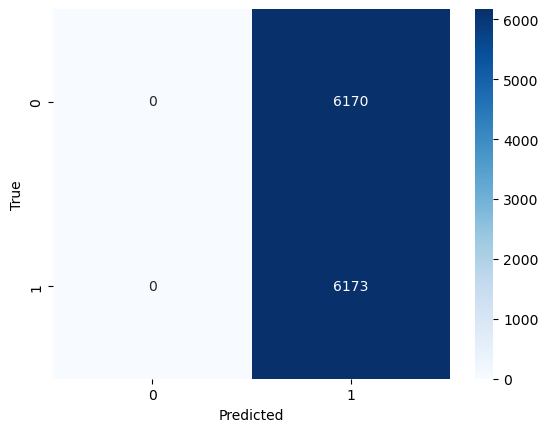

In [75]:
metricas(y_pred, y_test)

Estas metricas son muy similares a la anterior pero exactamente al reves. Tiene tambien una exactitud del 50% por lo que tambien es un modelo que se descartara a la hora de elegir el mejor.

#### Modelo SVM con kernel lineal

In [76]:
#Creo un clasificador con kernel lineal
clf = SVC(kernel='linear', C=5)
clf.fit(x_train_minmax, y_train)

y_pred_lin=clf.predict(x_test_minmax)

#### Metricas

              precision    recall  f1-score   support

           0       0.74      0.81      0.77      6170
           1       0.79      0.71      0.75      6173

    accuracy                           0.76     12343
   macro avg       0.76      0.76      0.76     12343
weighted avg       0.76      0.76      0.76     12343



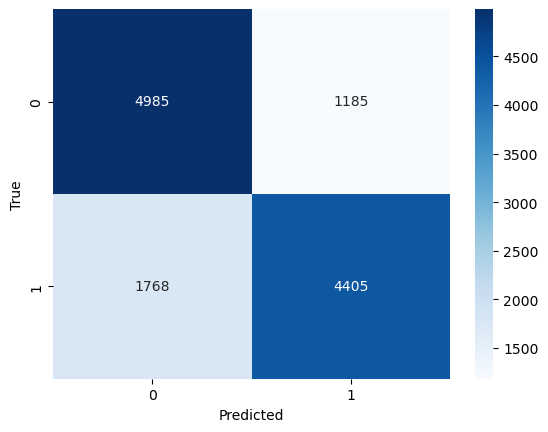

In [77]:
metricas(y_pred_lin, y_test)

Precision: En este caso, la precisión para la clase 0 es del 0.74, lo que significa que el 74% de las predicciones clasificadas como clase 0 son realmente de la clase 0. y el 79% para clase 1.

Recall: En este caso, el recall para la clase 0 es del 81%. Y vemos que para las instancias de clase 1, el 71% se ha identificado correctamente.

F1-score: Teniendo en cuenta que un valor de 1 indica un rendimiento perfecto, mientras que un valor de 0 indica un rendimiento pobre. En este caso, el f1-score para la clase 0 es del 0.77, lo que muestra un rendimiento aceptable para esa clase.

Exactitud: En este caso, la exactitud general del modelo es del 0.76, lo que indica que el 76% de las predicciones son correctas en general. Es un modelo medianamente aceptable, pero hemos encontrado uno mejor.

#### Modelo SVM con kernel polinomico


In [32]:
clf = SVC(kernel='poly', C=5, degree=3, gamma='scale')
clf.fit(x_train_minmax, y_train)

y_pred_pol = clf.predict(x_test_minmax)

#### Metricas

              precision    recall  f1-score   support

           0       0.75      0.85      0.80      6170
           1       0.83      0.72      0.77      6173

    accuracy                           0.79     12343
   macro avg       0.79      0.79      0.79     12343
weighted avg       0.79      0.79      0.79     12343



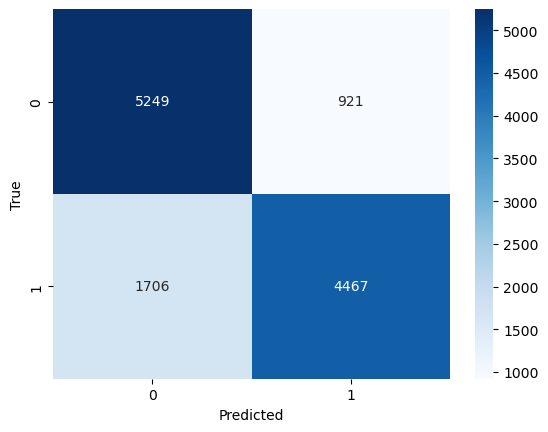

In [33]:
metricas(y_pred_pol,y_test)

Precision: En este caso, la precisión para la clase 0 es del 0.75, lo que significa que el 75% de las predicciones clasificadas como clase 0 son realmente de la clase 0. Para la clase 1 la precisión es del 83%.

Recall: En este caso, el recall para la clase 0 es del 85%. Y para la clase 1 es del 72%.

F1-score: Teniendo en cuenta que un valor de 1 indica un rendimiento perfecto, mientras que un valor de 0 indica un rendimiento pobre. En este caso, el f1-score para la clase 0 es del 0.80, lo que muestra un rendimiento aceptable para esa clase.

Exactitud: En este caso, la exactitud general del modelo es del 0.79, lo que indica que el 79% de las predicciones son correctas en general. Es un modelo medianamente aceptable.

#### Modelo SVM con kernel sigmoid

In [41]:
clf = SVC(kernel='sigmoid', C=1.0, gamma='auto')
clf.fit(x_train_minmax, y_train)

y_pred_rad=clf.predict(x_test_minmax)

#### Metricas

              precision    recall  f1-score   support

           0       0.71      0.81      0.76      6170
           1       0.78      0.68      0.72      6173

    accuracy                           0.74     12343
   macro avg       0.75      0.74      0.74     12343
weighted avg       0.75      0.74      0.74     12343



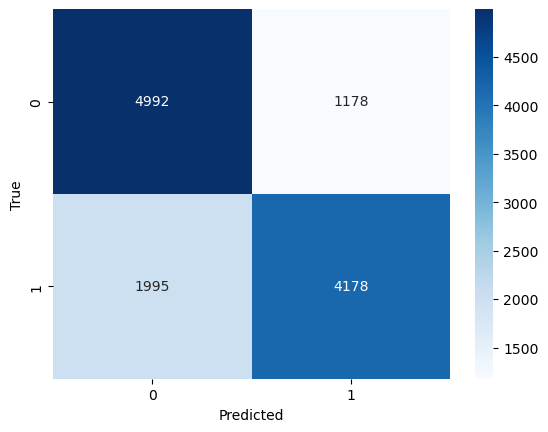

In [42]:
metricas(y_pred_rad,y_test)

Precision: En este caso, la precisión para la clase 0 es del 0.71, lo que significa que el 71% de las predicciones clasificadas como clase 0 son realmente de la clase 0. Para la clase 1 la presición es de 78%.

Recall: En este caso, el recall para la clase 0 es del 81%. Y para la clase 1 es del 68%.

F1-score: Teniendo en cuenta que un valor de 1 indica un rendimiento perfecto, mientras que un valor de 0 indica un rendimiento pobre. En este caso, el f1-score para la clase 0 es del 0.76, lo que musetra un rendimiento aceptable.

Exactitud: En este caso, la exactitud general del modelo es del 0.74, lo que indica que el 74% de las predicciones son correctas en general. Hemos encontrado modelos con mejores resultados

#### Selección del mejor modelo SVC

Nos quedamos con el kernel polinómico, que tuvo un mejor score.

In [31]:
clf = SVC(kernel='poly', C=5, degree=3, gamma='scale')
clf.fit(x_train_minmax, y_train)

models["svm"] = clf
model_scores["svm"] = 0.80

### Clasificador Random Forest

##### Construccion del RF con hiperparametros arbitrarios

In [42]:
rfc = RandomForestClassifier(max_features='sqrt', 
                             oob_score=True, 
                             random_state=2, 
                             n_jobs=-1,
                             criterion="entropy", 
                             min_samples_leaf=5,
                             min_samples_split=5,
                             n_estimators=50 )

model = rfc.fit(X = x_train, y = y_train)
y_pred = model.predict(x_test)

#### Metricas

              precision    recall  f1-score   support

           0       0.81      0.87      0.84      6170
           1       0.86      0.80      0.83      6173

    accuracy                           0.83     12343
   macro avg       0.83      0.83      0.83     12343
weighted avg       0.83      0.83      0.83     12343



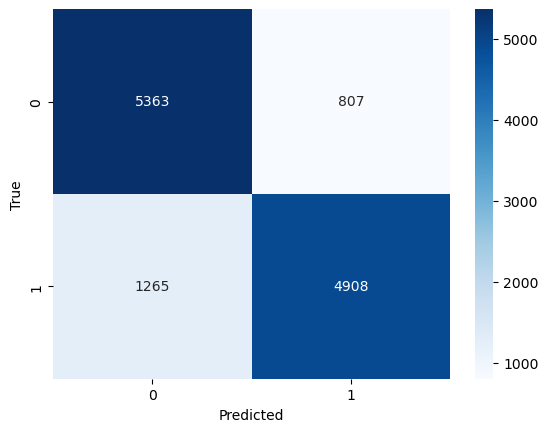

In [44]:
metricas(y_pred,y_test)

Precision: En este caso, la precisión para la clase 0 es de 0.81, lo que significa que el 81% de las predicciones clasificadas como clase 0 son realmente de la clase 0. Para la clase 1 se observa un 86%.

Recall: En este caso, el recall para la clase 0 es del 0.87, mientras que para las clase 1 es de 0.80.

F1-score: Teniendo en cuenta que un valor de 1 indica un rendimiento perfecto, mientras que un valor de 0 indica un rendimiento pobre, el f1-score para la clase 0 es del 0.84, lo que muestra un rendimiento aceptable para esa clase.

Exactitud: En este caso, la exactitud general del modelo es del 0.83, lo que indica que el 83% de las predicciones son correctas en general. El mejor modelo hasta el momento.

#### RF con hiperparametros optimizados

In [63]:
FOLDS = 6
kfold = StratifiedKFold(n_splits=FOLDS)
scorer_fn = make_scorer(f1_score, zero_division=1)

rf_cv = RandomForestClassifier(max_features='sqrt', oob_score=True, random_state=1, n_jobs=-1)

param_grid = { "criterion" : ["gini", "entropy"], 
               "min_samples_leaf" : [1, 5, 10], 
               "min_samples_split" : [2, 4, 10, 12, 16], 
               "n_estimators": [100, 200, 2000] }

#Probamos entrenando sólo con 1 métrica
gs = HalvingGridSearchCV(estimator=rf_cv, param_grid=param_grid, scoring=scorer_fn, cv=kfold, n_jobs=-1)
gs_fit = gs.fit(X = x_train, y = y_train)

# Mostrar los mejores hiperparámetros y la métrica de desempeño del modelo
print('Mejores hiperparámetros:', gs.best_params_)
print('Mejor score:', gs.best_score_)

In [32]:
# Guardamos los mejores parametros para no tener que correr todo de nuevo
rf_best_params = {'criterion': 'entropy', 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 2000}

In [33]:
best_rf = RandomForestClassifier(max_features='sqrt', oob_score=True, random_state=1, n_jobs=-1, **rf_best_params)

# Entrenar el modelo con los datos de entrenamiento
best_rf.fit(x_train, y_train)

# Realizar predicciones en datos de prueba
y_pred_rf_cv_best = best_rf.predict(x_test)

In [34]:
models["rf"] = best_rf
model_scores["rf"] = 0.85

#### Metricas

              precision    recall  f1-score   support

           0       0.83      0.87      0.85      6170
           1       0.87      0.82      0.84      6173

    accuracy                           0.85     12343
   macro avg       0.85      0.85      0.85     12343
weighted avg       0.85      0.85      0.85     12343



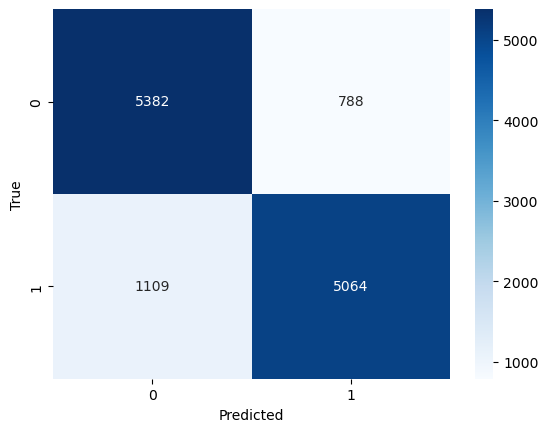

In [79]:
metricas(y_pred_rf_cv_best,y_test)

Precision: En este caso, la precisión para la clase 0 es del 0.83, lo que significa que el 83% de las predicciones clasificadas como clase 0 son realmente de la clase 0. Y el 87% para la clase 1.

Recall: En este caso, el recall para la clase 0 es del 0.88, lo que indica que el 88% de las instancias de la clase 0 se han identificado correctamente. Y vemos que para las instancias de clase 1, el 82% se ha identificado correctamente.

F1-score: Teniendo en cuenta que un valor de 1 indica un rendimiento perfecto, mientras que un valor de 0 indica un rendimiento pobre. En este caso, el f1-score para la clase 0 es del 0.85, y para clase 1 es del 0.84 lo que muestra un rendimiento aceptable para esa clase.

Exactitud: En este caso, la exactitud general del modelo es del 0.85, lo que indica que el 85% de las predicciones son correctas en general. Lo que ahora lo convierte en el mejor modelo, pasando al random forest con hiperparametros arbitrarios.

### XGBoost

#### Busqueda de mejores Hiperparametros para XGBoost

In [ ]:
FOLDS = 6

kfold = StratifiedKFold(n_splits=FOLDS)
x = ds[features]
y = ds[target]

scorer_fn = make_scorer(f1_score, zero_division=1)

parametros = {
    'n_estimators': [200, 2000],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': list(range(1, 11)),
    'min_child_weight': list(range(1, 11)),
    'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1],
    'colsample_bytree': [0.5, 0.6, 0.7, 0.8, 0.9, 1],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4, 0.5]
}

modelo = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=13
)

grid = HalvingGridSearchCV(modelo, parametros, scoring=scorer_fn, cv=kfold, n_jobs=-1, random_state=13)

# Training the model
grid.fit(x, y)

print(grid.best_score_)
print(grid.best_params_)

xgb_best_params = grid.best_params_

In [35]:
# Guardamos los mejores parametros encontrados para no correr todo el tiempo la busqueda
xgb_best_params = best_params = {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 10, 'min_child_weight': 1, 'n_estimators': 2000, 'subsample': 0.9} #XGBoost - f1=0.8392294074354546

#### Prediccion sobre el set de testeo

In [36]:
# Hacemos predicción sobre el set de evaluacion
xgb = XGBClassifier(
    objective='binary:logistic',  # Binary classification
    eval_metric='logloss',        # Default evaluation metric for binary classification
    colsample_bytree=xgb_best_params['colsample_bytree'],
    gamma=xgb_best_params['gamma'],
    learning_rate=xgb_best_params['learning_rate'],
    max_depth=xgb_best_params['max_depth'],
    min_child_weight=xgb_best_params['min_child_weight'],
    n_estimators=xgb_best_params['n_estimators'],
    subsample=xgb_best_params['subsample']
)

xgb.fit(x, y)
y_pred = xgb.predict(x_test)

In [37]:
models["xgb"] = xgb
model_scores["xgb"] = 0.92

#### Metricas

              precision    recall  f1-score   support

           0       0.91      0.93      0.92      6170
           1       0.93      0.91      0.92      6173

    accuracy                           0.92     12343
   macro avg       0.92      0.92      0.92     12343
weighted avg       0.92      0.92      0.92     12343



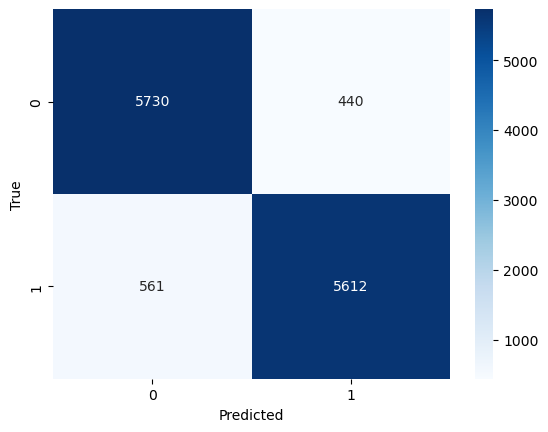

In [40]:
metricas(y_pred, y_test)

Precision: En este caso, la precisión para la clase 0 es del 0.91, lo que significa que el 91% de las predicciones clasificadas como clase 0 son realmente de la clase 0. Y el 93% para la clase 1.

Recall: En este caso, el recall para la clase 0 es del 0.93, lo que indica que el 93% de las instancias de la clase 0 se han identificado correctamente. Y vemos que para las instancias de clase 1, el 91% se ha identificado correctamente.

F1-score: Teniendo en cuenta que un valor de 1 indica un rendimiento perfecto, mientras que un valor de 0 indica un rendimiento pobre. En este caso, el f1-score para la clase 0 es del 0.92 tanto para la clase 0 como para la 1, mostrando un rendimiento bastante bueno para estas clases.

Exactitud: En este caso, la exactitud general del modelo es del 0.92, lo que indica que el 92% de las predicciones son correctas en general. Lo que ahora lo convierte en el mejor modelo, pasando a todos los modelos anteriores.

### Voting

In [41]:
from sklearn.ensemble import VotingClassifier

#Creo el ensamble
vot_clf = VotingClassifier(estimators=[('xgb', models["xgb"]), ('rf', models["rf"]), ('svm', models["svm"]), ('knn', models["knn"])], voting='hard')

#Entreno el ensamble
vot_clf.fit(x_train, y_train)

#Predigo con el ensamble
y_pred = vot_clf.predict(x_test)

In [ ]:
models["vot"] = vot_clf
model_scores["vot"] = 0.85

              precision    recall  f1-score   support

           0       0.81      0.90      0.85      6170
           1       0.88      0.78      0.83      6173

    accuracy                           0.84     12343
   macro avg       0.84      0.84      0.84     12343
weighted avg       0.84      0.84      0.84     12343



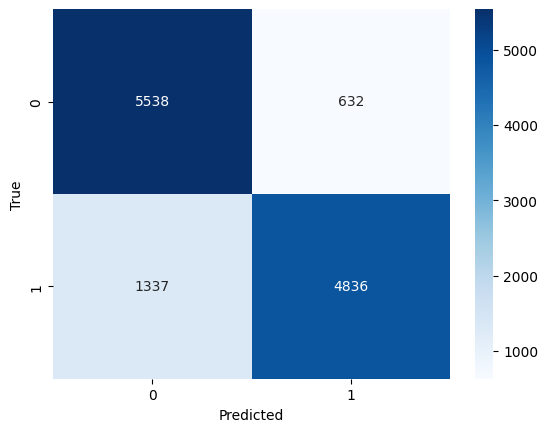

In [42]:
metricas(y_pred, y_test)

Precision: En este caso, la precisión para la clase 0 es del 0.81, lo que significa que el 81% de las predicciones clasificadas como clase 0 son realmente de la clase 0. Y el 88% para la clase 1.

Recall: En este caso, el recall para la clase 0 es del 0.90, lo que indica que el 90% de las instancias de la clase 0 se han identificado correctamente. Y vemos que para las instancias de clase 1, el 78% se ha identificado correctamente.

F1-score: Teniendo en cuenta que un valor de 1 indica un rendimiento perfecto, mientras que un valor de 0 indica un rendimiento pobre. En este caso, el f1-score para la clase 0 es del 0.85 tanto para la clase 0 como para la 1, mostrando un rendimiento aceptable

Exactitud: En este caso, la exactitud general del modelo es del 0.84, lo que indica que el 84% de las predicciones son correctas en general. No es un mal rendimiento, pero considerando que utiliza XGBoost, que por sí solo tiene mejores métricas, podría ser mucho mejor.

### Stacking

In [44]:
stacking_clf = StackingClassifier(estimators=[('xgb', models["xgb"]), ('rf', models["rf"]), ('svm', models["svm"]), ('knn', models["knn"])], 
                                  final_estimator=LogisticRegression(), 
                                  cv=5, 
                                  verbose=2,
                                  n_jobs=-1)

stacking_clf.fit(x_train, y_train)

y_pred = stacking_clf.predict(x_test)

In [ ]:
models["stack"] = stacking_clf
model_scores["stack"] = 0.85

In [ ]:
metricas(y_pred, y_test)